In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from pathlib import Path
from pyEllipse import hotelling_parameters, hotelling_coordinates, confidence_ellipse

In [6]:
img_dir = Path("images")
img_dir.mkdir(exist_ok=True)
plt.style.use('seaborn-v0_8-darkgrid') 

In [7]:
def load_wine_data():
    """Load wine dataset and add cultivar labels"""
    wine_df = pd.read_csv('data/wine.csv')
    
    # Add cultivar labels based on standard Wine dataset structure
    cultivar = []
    for i in range(len(wine_df)):
        if i < 59:
            cultivar.append('Cultivar 1')
        elif i < 130:
            cultivar.append('Cultivar 2')
        else:
            cultivar.append('Cultivar 3')
    
    wine_df['Cultivar'] = cultivar
    return wine_df

In [10]:
wine_df = load_wine_data()
X = wine_df.drop('Cultivar', axis=1)
y = wine_df['Cultivar']

In [11]:
# Perform PCA
pca = PCA()
pca_scores = pca.fit_transform(X)

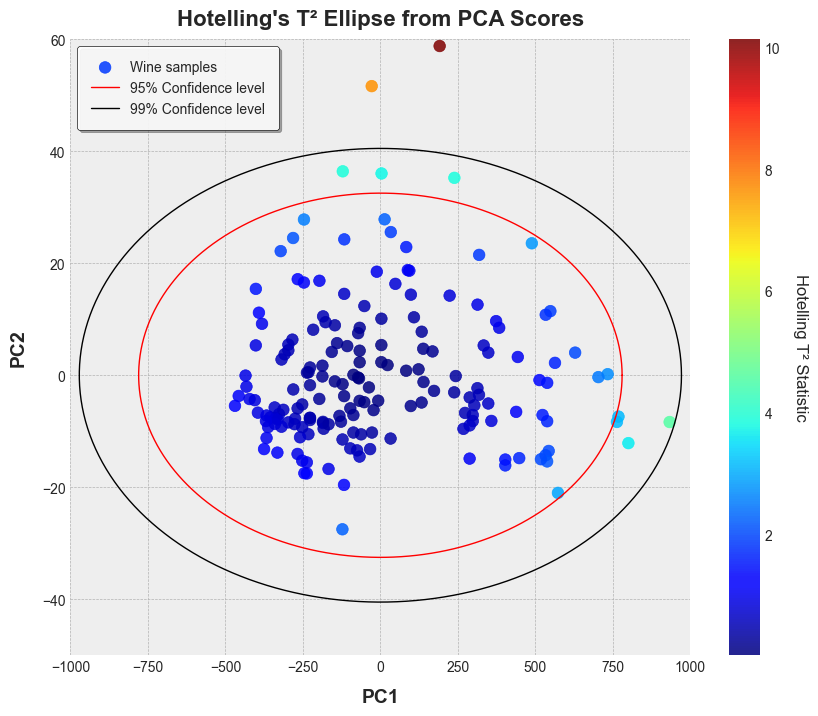

In [17]:
plt.style.use('bmh')
# Calculate T² statistics
results = hotelling_parameters(pca_scores, k=2)
t2 = results['Tsquared'].values

# Generate ellipse coordinates for plotting
ellipse_95 = hotelling_coordinates(pca_scores, pcx=1, pcy=2, conf_limit=0.95)
ellipse_99 = hotelling_coordinates(pca_scores, pcx=1, pcy=2, conf_limit=0.99)

# Plotting the PCA scores with Hotelling's T² ellipse
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_scores[:, 0], pca_scores[:, 1], c=t2, cmap='jet', alpha=0.85, s=70, label='Wine samples')
cbar = plt.colorbar(scatter)
cbar.set_label('Hotelling T² Statistic', rotation=270, labelpad=20)

plt.plot(ellipse_95['x'], ellipse_95['y'], 'r-', linewidth=1, label='95% Confidence level')
plt.plot(ellipse_99['x'], ellipse_99['y'], 'k-', linewidth=1, label='99% Confidence level')
plt.xlim(-1000, 1000)
plt.ylim(-50, 60)
plt.xlabel('PC1', fontsize=14, labelpad=10, fontweight='bold')
plt.ylabel('PC2', fontsize=14, labelpad=10, fontweight='bold')
plt.title("Hotelling's T² Ellipse from PCA Scores", fontsize=16, pad=10, fontweight='bold')
plt.legend(loc='upper left', fontsize=10, frameon=True, framealpha=0.9, edgecolor='black', shadow=True, facecolor='white', borderpad=1)
plt.show()

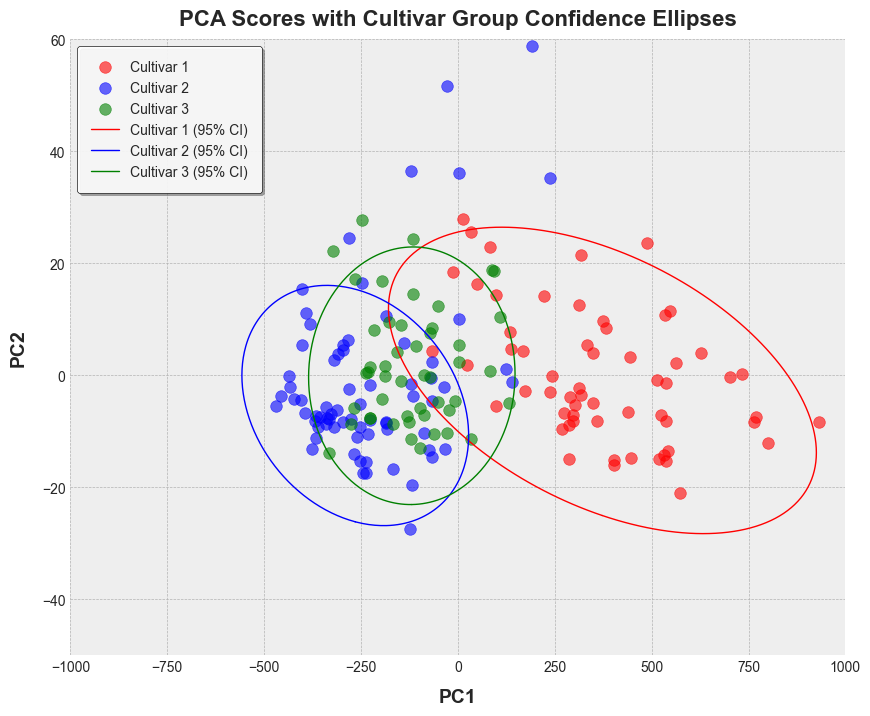

In [20]:
wine_df['PC1'] = pca_scores[:, 0]
wine_df['PC2'] = pca_scores[:, 1]

colors = ['red', 'blue', 'green']
cultivars = wine_df['Cultivar'].unique()
color_map = {cultivar: color for cultivar, color in zip(cultivars, colors)}
point_colors = wine_df['Cultivar'].map(color_map)

# Plotting PCA scores with confidence ellipses for each cultivar
plt.figure(figsize=(10, 8))

for i, cultivar in enumerate(cultivars):
    mask = wine_df['Cultivar'] == cultivar
    plt.scatter(wine_df.loc[mask, 'PC1'], wine_df.loc[mask, 'PC2'], c=colors[i], alpha=0.6, s=70, label=cultivar) # type: ignore

ellipse_coords = confidence_ellipse(
    data=wine_df,
    x='PC1',
    y='PC2',
    group_by='Cultivar',
    conf_level=0.95,
    robust=True,
    distribution='hotelling'
)

for i, cultivar in enumerate(cultivars):
    ellipse_data = ellipse_coords[ellipse_coords['Cultivar'] == cultivar]
    plt.plot(ellipse_data['x'], ellipse_data['y'], color=colors[i], linewidth=1, linestyle='-', label=f'{cultivar} (95% CI)')

plt.xlim(-1000, 1000)
plt.ylim(-50, 60)
plt.xlabel('PC1', fontsize=14, labelpad=10, fontweight='bold')
plt.ylabel('PC2', fontsize=14, labelpad=10, fontweight='bold')
plt.title("PCA Scores with Cultivar Group Confidence Ellipses", fontsize=16, pad=10, fontweight='bold')
plt.legend(loc='upper left', fontsize=10, frameon=True, framealpha=0.9, edgecolor='black', shadow=True, facecolor='white', borderpad=1)
plt.show()